# Lecture 8: Object Detection & Location

ref: https://sjtu-robomaster-team.github.io/

In [122]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt

## 图像的数字表示 & 三原色

In [123]:
img = cv2.imread('img/google.png')
img.shape

(268, 693, 3)

#### **RGB颜色空间： Red，Green, Blue**

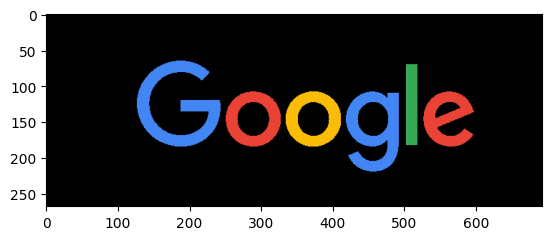

In [124]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
red, green, blue = cv2.split(img)
plt.imshow(img)

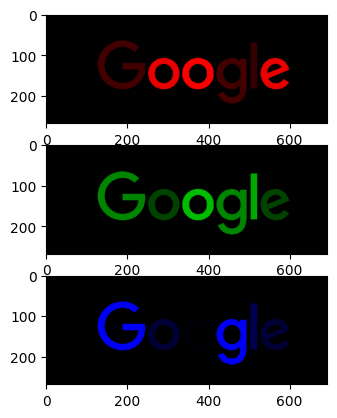

(<Figure size 640x480 with 3 Axes>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 None)

In [125]:
only_red = cv2.merge([red, green * 0, blue * 0])
only_green = cv2.merge([red * 0, green, blue * 0])
only_blue = cv2.merge([red * 0, green * 0, blue])
plt.figure(), plt.subplot(311), plt.imshow(only_red), plt.subplot(312), plt.imshow(only_green), plt.subplot(313), plt.imshow(only_blue), plt.show()

#### **HSV颜色空间： Hue, Saturation, Value**

<img src="./img/hsv.png" alt="hsv space" width="400" />

[HSV颜色](./hsv.html)

## 灰度图

每个像素点只有一个值，表示灰度值。0表示黑色，255表示白色。

OpenCV 提供了将彩色图转换为灰度图的函数

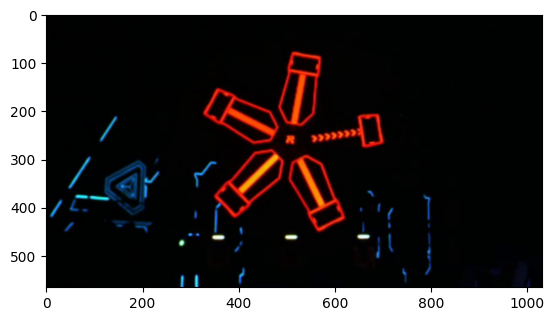

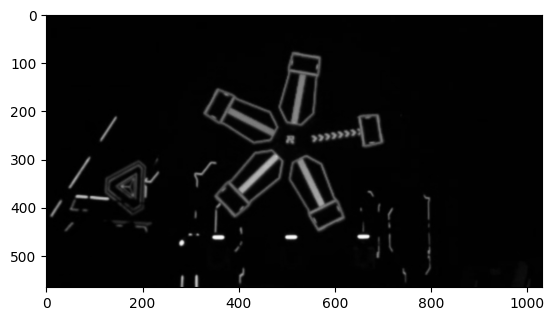

(<matplotlib.image.AxesImage at 0x169996510>, None)

In [126]:
img = cv2.imread('img/rune.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # cv::cvtColor()
# plt.figure(), plt.subplot(211), plt.imshow(img_rgb, cmap='gray'), plt.title('Original'), plt.subplot(212), plt.imshow(img_gray, cmap='gray'), plt.title('gray'), plt.show()
plt.imshow(img_rgb, cmap='gray'), plt.show()
plt.imshow(img_gray, cmap='gray'), plt.show()

## 二值图

特殊的灰度图，像素点的灰度只有0和255两种情况

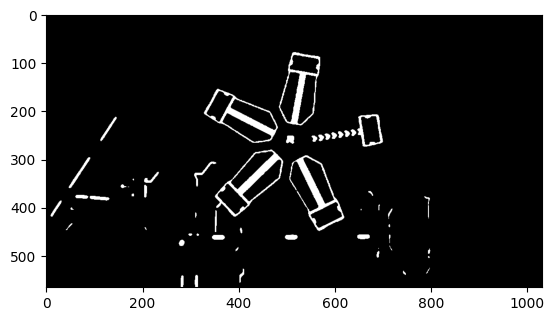

(<matplotlib.image.AxesImage at 0x16bf71190>, None)

In [127]:
img_binary = cv2.threshold(img_gray, 70, 255, cv2.THRESH_BINARY)
plt.imshow(img_binary[1], cmap='gray'), plt.show()

### 卷积&形态学运算  

#### **腐蚀：取邻域的最小值**

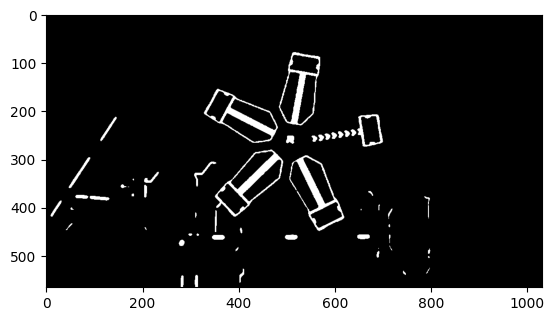

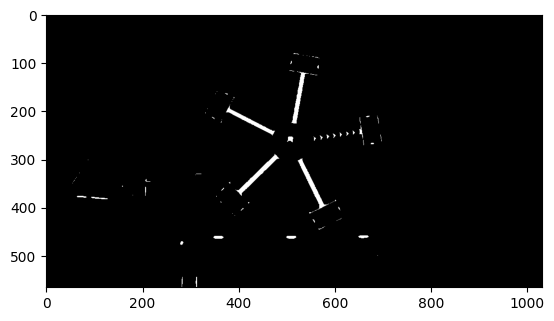

(<matplotlib.image.AxesImage at 0x147c22c60>, None)

In [128]:
img_copy = img_binary[1].copy()
kernel = np.ones((5, 5), np.uint8)
img_erode = cv2.erode(img_copy, kernel, iterations=1)
plt.imshow(img_copy, cmap='gray'), plt.show()
plt.imshow(img_erode, cmap='gray'), plt.show()

#### **膨胀：取邻域的最大值**

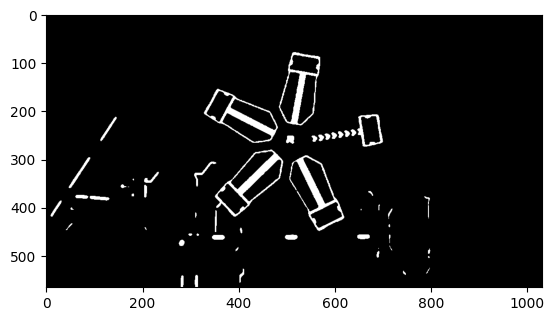

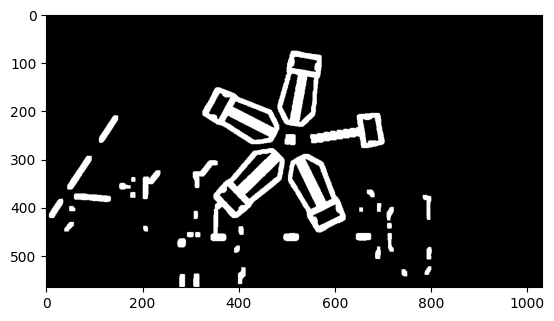

(<matplotlib.image.AxesImage at 0x1472764e0>, None)

In [129]:
img_copy = img_binary[1].copy()
kernel = np.ones((7, 7), np.uint8)
img_dilate = cv2.dilate(img_copy, kernel, iterations=1)
plt.imshow(img_copy, cmap='gray'), plt.show()
plt.imshow(img_dilate, cmap='gray'), plt.show()

#### **开运算：先腐蚀再膨胀**

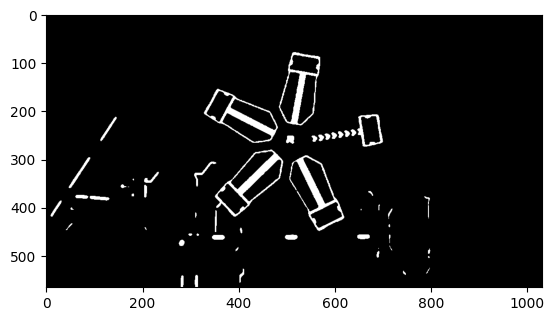

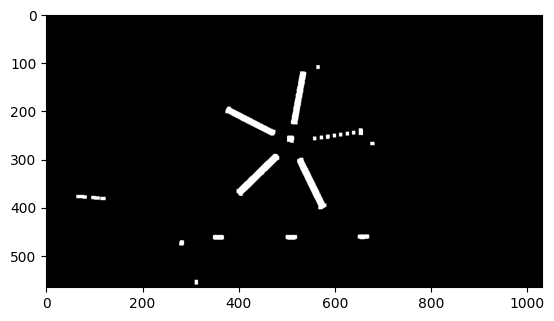

(<matplotlib.image.AxesImage at 0x146d41130>, None)

In [130]:
img_copy = img_binary[1].copy()
kernel = np.ones((7, 7), np.uint8)
img_opening = cv2.morphologyEx(img_copy, cv2.MORPH_OPEN, kernel)
plt.imshow(img_copy, cmap='gray'), plt.show()
plt.imshow(img_opening, cmap='gray'), plt.show()

#### **闭运算：先膨胀再腐蚀**

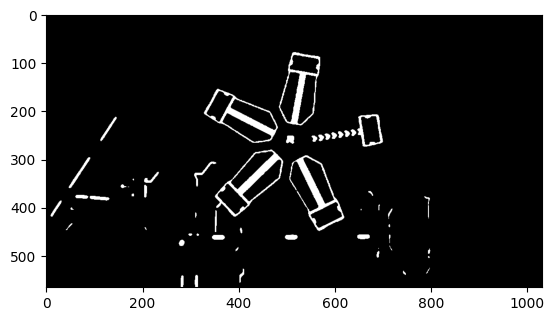

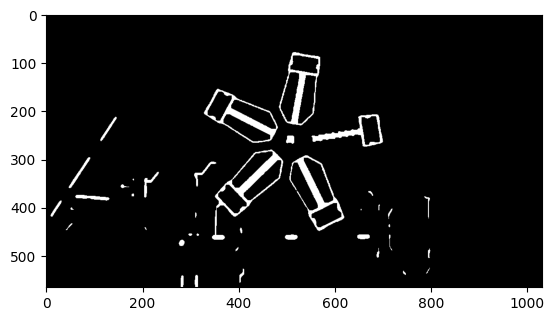

(<matplotlib.image.AxesImage at 0x16ca68da0>, None)

In [131]:
img_copy = img_binary[1].copy()
kernel = np.ones((7, 7), np.uint8)
img_closing = cv2.morphologyEx(img_copy, cv2.MORPH_CLOSE, kernel)
plt.imshow(img_copy, cmap='gray'), plt.show()
plt.imshow(img_closing, cmap='gray'), plt.show()

## 轮廓提取



[OpenCV Doc](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=findcontours#findcontours)

- **轮廓:** 一组点，这些点连接在一起可以形成一个封闭的曲线。

- **轮廓提取:** 

```cpp
void findContours(InputOutputArray image, OutputArrayOfArrays contours, int mode, int method, Point offset=Point());
```

`image`: 输入图像

`contours`: 输出的轮廓

`offset`: 轮廓偏移。返回结果中的每个点都会加上这个偏移量。

`mode`: 轮廓检索模式。

- `CV_RETR_EXTERNAL`: 只检测外轮廓
- 
- `CV_RETR_LIST`: 检测所有轮廓, 以列表形式返回
- 
- `CV_RETR_TREE`: 检测所有轮廓, 以树形结构返回

`method`: 轮廓逼近方法。

- `CV_CHAIN_APPROX_NONE`: 存储所有的轮廓点

- `CV_CHAIN_APPROX_SIMPLE`: 压缩水平、垂直、对角方向，只保留端点


**Example:**

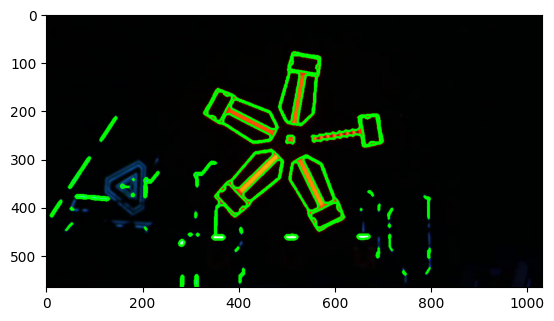

(<matplotlib.image.AxesImage at 0x147b470e0>, None)

In [132]:
img_copy = img_closing.copy()
contours, hierarchy = cv2.findContours(img_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_rgb_copy = img_rgb.copy()
cv2.drawContours(img_rgb_copy, contours, -1, (0, 255, 0), 3) # std::vector<std::vector<cv::Point>>
plt.imshow(img_rgb_copy), plt.show()

## 轮廓筛选

### 依照轮廓的几何学特征，筛选出可用的轮廓

/var/folders/lb/ndwclnm975d_4zb3627dhwj40000gn/T/ipykernel_32089/1623172447.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(rect))


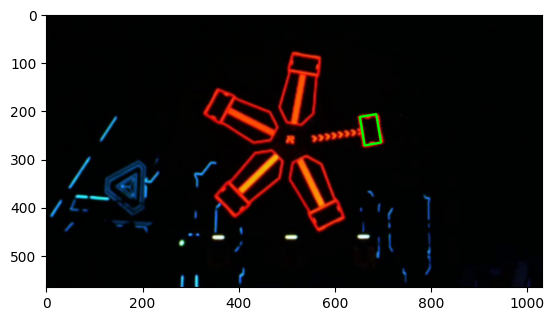

(<matplotlib.image.AxesImage at 0x16cac7440>, None)

In [133]:
result_contour = []
for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    
    # 面积过小
    if area < 100:
        continue
    
    # 外接旋转矩形宽高比过大
    rect = cv2.minAreaRect(contours[i])
    width, height = rect[1]
    if max(width, height) / min(width, height) > 2:
        continue
    
    # 有子轮廓
    if hierarchy[0][i][3] == -1:
        continue
    
    # 和父轮廓面积比过小
    if area / cv2.contourArea(contours[hierarchy[0][i][3]]) < 0.3:
        continue
    result_contour.append(contours[i])
    
    sorted(result_contour, key=cv2.contourArea, reverse=True)
    
# 取result_contour中第一个(面积最大的)轮廓的旋转矩形的角点
rect = cv2.minAreaRect(result_contour[0])
box = np.int0(cv2.boxPoints(rect))
cv2.drawContours(img_rgb, [box], 0, (0, 255, 0), 3)
plt.imshow(img_rgb), plt.show()
